In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import qgrid
from tqdm.auto import tqdm
import re

sns.set(style="ticks", palette="muted", color_codes=True)

warnings.filterwarnings("ignore")

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20

seed = 42

In [2]:
def show_tbl(df):
    return qgrid.show_grid(df, show_toolbar=True)

In [3]:
df = pd.read_csv("datasets/Combined_air_pollutants_data_with_caqi.csv", parse_dates=['DATE'])

In [4]:
df.head(3)

index                              powiat_voivod       DATE        LAT  \
0      0  powiat aleksandrowski, kujawsko-pomorskie 2017-01-01  52.888422   
1      1  powiat aleksandrowski, kujawsko-pomorskie 2017-01-02  52.888422   
2      2  powiat aleksandrowski, kujawsko-pomorskie 2017-01-03  52.888422   

         LON  NO2_24H_AVG_POLLUTION  O3_24H_AVG_POLLUTION  \
0  18.780908                    NaN                 32.22   
1  18.780908                    NaN                 34.62   
2  18.780908                    NaN                 42.00   

   PM10_24H_AVG_POLLUTION  PM25_24H_AVG_POLLUTION        CC  ...  \
0               24.968064                     NaN  4.746750  ...   
1               17.943745                     NaN  6.167555  ...   
2               14.477950                     NaN  5.198131  ...   

   [crop production] sugar beets, area in ha, total  \
0                                            1184.0   
1                                            1184.0   
2                                            1184.0   

   [crop production] rape and turnip rape, area in ha, total  \
0                                             2616.0           
1                                             2616.0           
2                                             2616.0           

   [crop production] permanent meadows, area in ha, total  \
0                                             2320.0        
1                                             2320.0        
2                                             2320.0        

   [crop production] permanent pastures, area in ha, total  NO2_sub_idx  \
0                                              406.0                NaN   
1                                              406.0                NaN   
2                                              406.0                NaN   

  O3_sub_idx  PM10_sub_idx  PM25_sub_idx   CAQI_idx  CAQI_level  
0     13.425     24.968064           NaN  24.968064        vlow  
1     14.425     17.943745           NaN  17.943745        vlow  
2     17.500     14.477950           NaN  17.500000        vlow  

[3 rows x 146 columns]

In [5]:
df.columns

Index(['index', 'powiat_voivod', 'DATE', 'LAT', 'LON', 'NO2_24H_AVG_POLLUTION',
       'O3_24H_AVG_POLLUTION', 'PM10_24H_AVG_POLLUTION',
       'PM25_24H_AVG_POLLUTION', 'CC',
       ...
       '[crop production] sugar beets, area in ha, total',
       '[crop production] rape and turnip rape, area in ha, total',
       '[crop production] permanent meadows, area in ha, total',
       '[crop production] permanent pastures, area in ha, total',
       'NO2_sub_idx', 'O3_sub_idx', 'PM10_sub_idx', 'PM25_sub_idx', 'CAQI_idx',
       'CAQI_level'],
      dtype='object', length=146)

In [6]:
#Creating variables to make visualization easier

#Pollutants
pollutant_cols = [
    'NO2_24H_AVG_POLLUTION',  'O3_24H_AVG_POLLUTION',  'PM10_24H_AVG_POLLUTION', 'PM25_24H_AVG_POLLUTION'
]

poll_dict = {col : "PM2.5" if col.startswith("PM25") else col.split("_")[0] for col in pollutant_cols}

#Weather
weather_cols = ['CC', 'FG', 'HU', 'RR', 'SD', 'TG']

weather_dict = {
    'CC' : "Cloud Cover", 
    "FG" : "Wind Speed",
    "HU" : "Humidity",
    "RR" : "Precipitation",
    "SD" : "Snow Depth",
    "TG" : "Temperature"
}

#### Pollutions

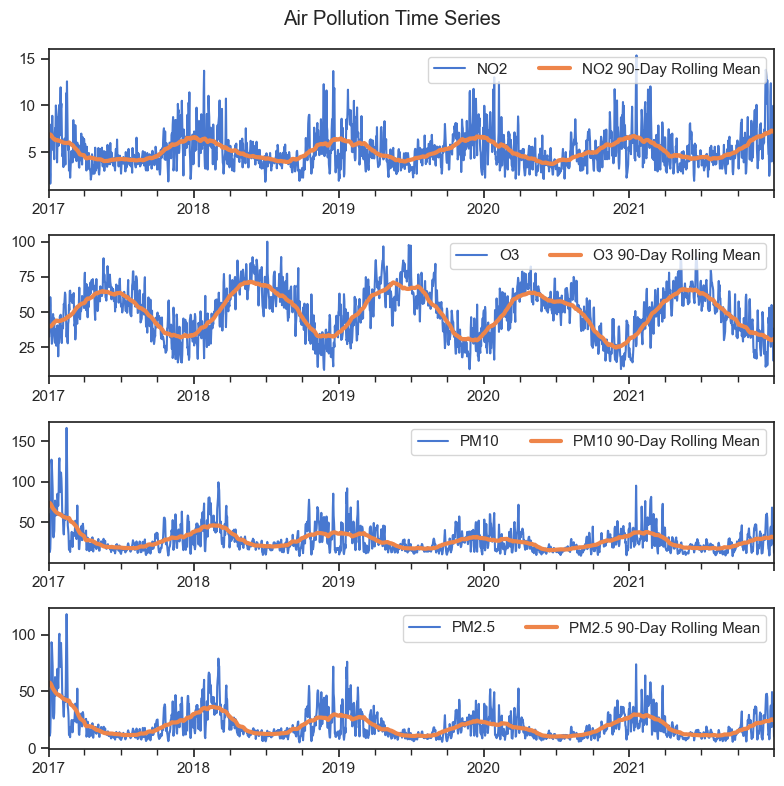

In [7]:
#Daily Time series of Pollutants
fig, axes = plt.subplots(4, 1, figsize=(8, 8), tight_layout=True)

for col, ax in zip(pollutant_cols, axes.flatten()):
    
    df.groupby('DATE')[col].mean().plot(ax=ax, label=poll_dict[col]);
    
    df.groupby('DATE')[col].mean().rolling(90, center=True, min_periods=30).mean().\
        plot(ax=ax, label=f'{poll_dict[col]} 90-Day Rolling Mean', lw=3);
    
    ax.legend(ncol=2, loc="upper right")
    ax.set_xlabel("")
    
plt.suptitle("Air Pollution Time Series");

Some of the pollutants shows measurements below Zero, which is not possible. Probably this is due to imputations of pollutant datasets. I will replace the zero and negative values with the respective lowest positive value for each pollutant.

In [8]:
#Replacing zero and negative values with the lowest positive value
for col in pollutant_cols:
    
    if df.loc[df[col].le(0), col].isnull().all():
        pass
    else:
        df.loc[df[col].le(0), col] = df.loc[df[col].gt(0), col].min()

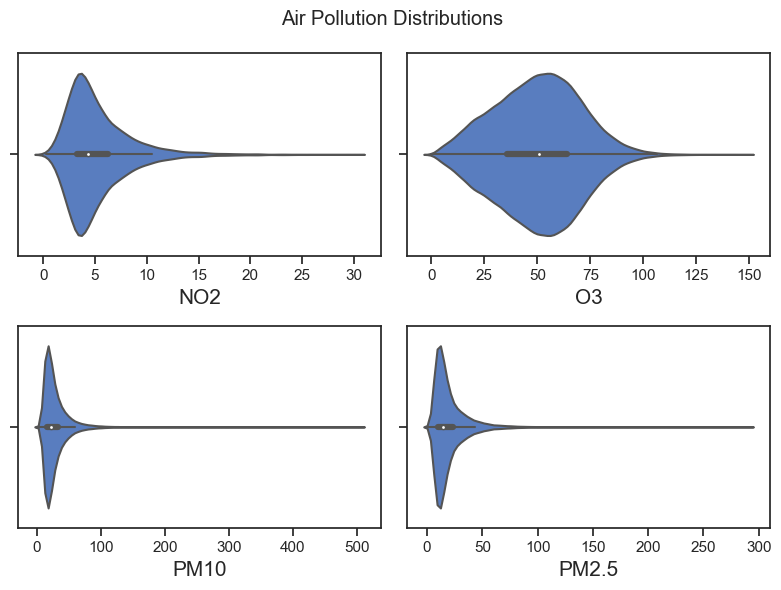

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6), tight_layout=True)

for col, ax in zip(pollutant_cols, axes.flatten()):
    
    sns.violinplot(df[col], ax=ax);
    ax.set_xlabel(poll_dict[col])
    
plt.suptitle("Air Pollution Distributions");

In [10]:
#Extracting day, month, year and dayofweek features from DATE
df['day'] = df['DATE'].dt.day
df['month'] = df['DATE'].dt.month
df['year'] = df['DATE'].dt.year
df['dayofweek'] = df['DATE'].dt.dayofweek

In [11]:
#Creating new column for seasons
#https://climateknowledgeportal.worldbank.org/country/poland/climate-data-historical
df.loc[df['month'].isin([9, 10, 11]), 'season'] = "Autumn"
df.loc[df['month'].isin([12, 1, 2]), 'season'] = "Winter"
df.loc[df['month'].isin([3, 4, 5]), 'season'] = "Spring"
df.loc[df['month'].isin([6, 7, 8]), 'season'] = "Summer"

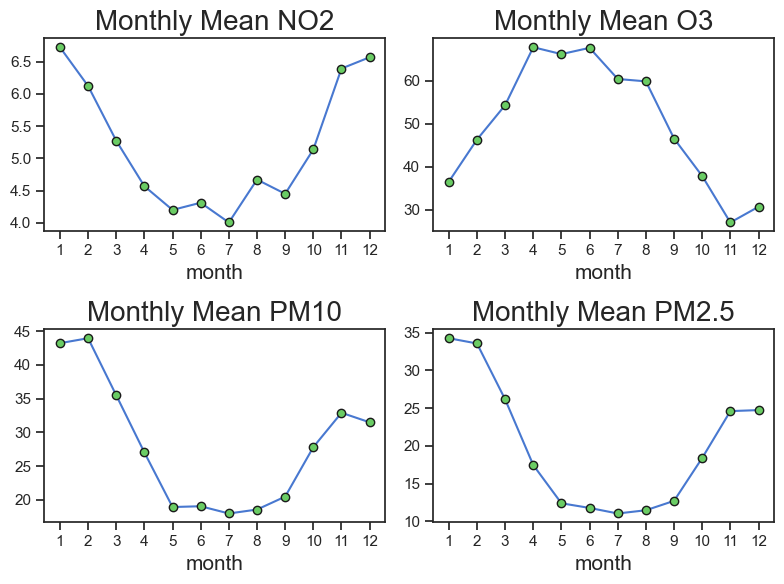

In [12]:
#Checking for monthly seasonality pattern
fig, axes = plt.subplots(2, 2, tight_layout=True, figsize=(8, 6))

for col, ax in zip(pollutant_cols, axes.flatten()):
    
    df.groupby('month')[col].mean().plot(ax=ax, marker="o", mfc="g", mec="k")
    ax.set_xticks(np.arange(1, 13, 1))
    ax.set_title(f'Monthly Mean {poll_dict[col]}');

O3 seems to be highest during summer and lowest during winter. The opposite is true for the other pollutants. Will need to compare with weather data to understand patterns.

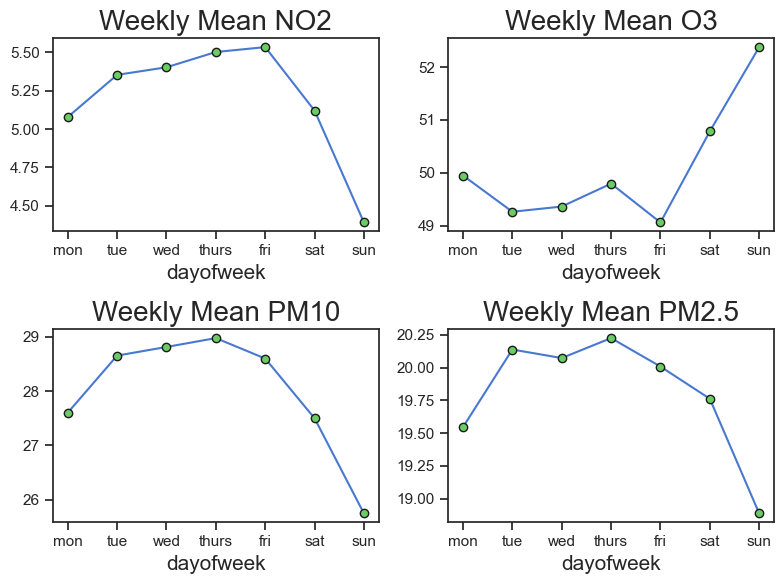

In [13]:
#Checking for weekly seasonality
days=["mon", "tue", "wed", "thurs", "fri", "sat", "sun"]

fig, axes = plt.subplots(2, 2, tight_layout=True, figsize=(8, 6))

for col, ax in zip(pollutant_cols, axes.flatten()):
    
    df.groupby('dayofweek')[col].mean().plot(ax=ax, marker="o", mfc="g", mec="k")
    ax.set_xticks(np.arange(7), days)
    ax.set_title(f'Weekly Mean {poll_dict[col]}');

For O3, measurements are higher during the weekends and lower during working days. Where as the other pollutants shows the opposite patterns. This is an interesting observation. Perhaps, this shows that pollution depends on the number of cars on the roads? Will need to look deeper into this.

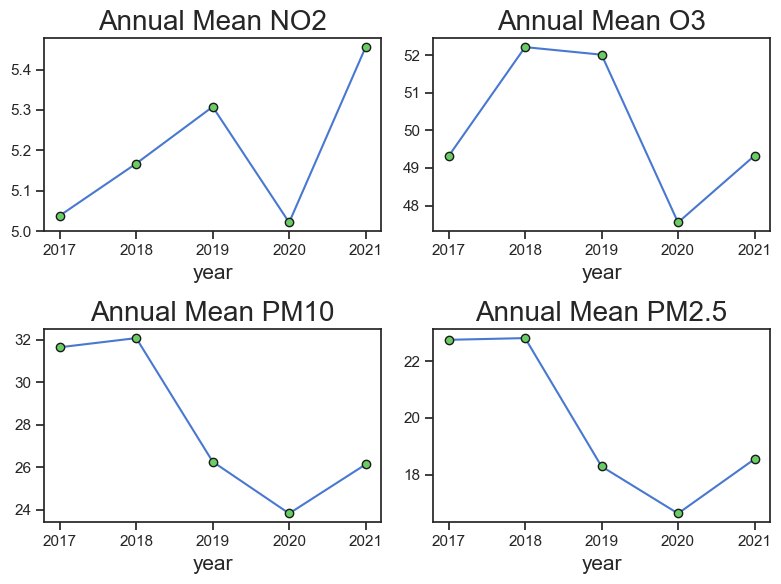

In [14]:
#Yearly Seasonality
fig, axes = plt.subplots(2, 2, tight_layout=True, figsize=(8, 6))

for col, ax in zip(pollutant_cols, axes.flatten()):
    
    df.groupby('year')[col].mean().plot(ax=ax, marker="o", mfc="g", mec="k")
    ax.set_title(f'Annual Mean {poll_dict[col]}');

#### Weather

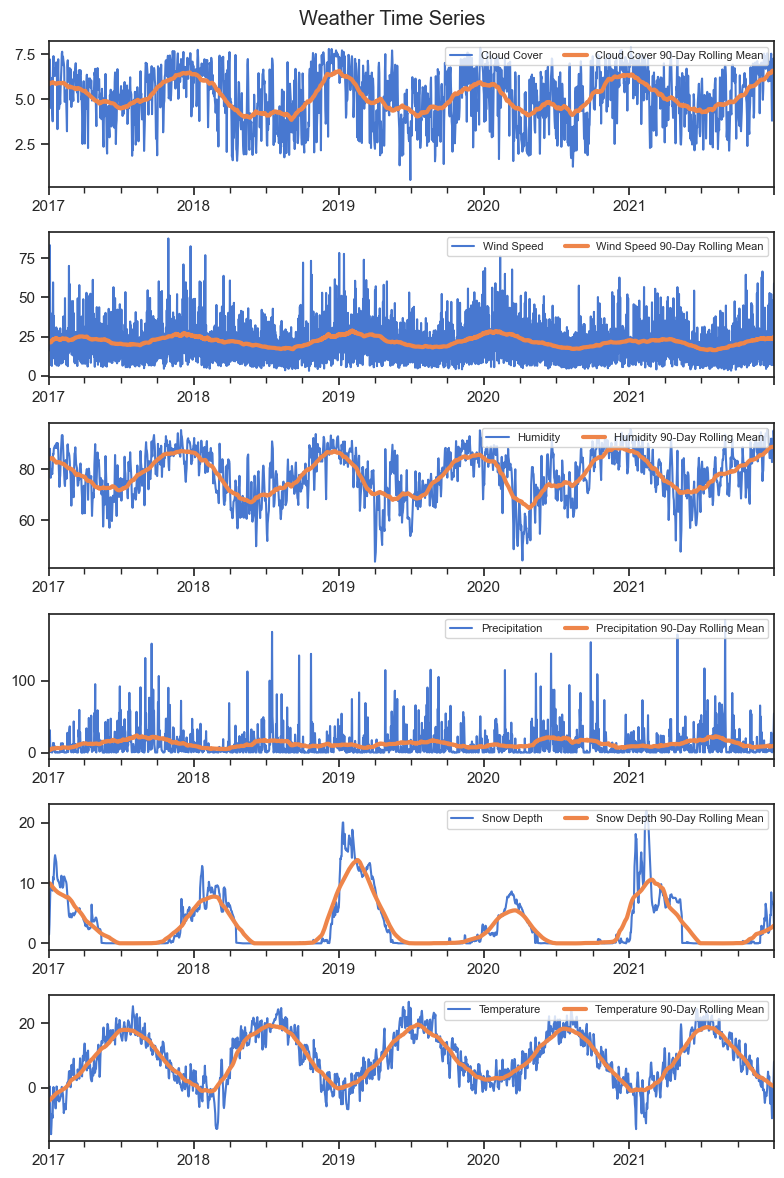

In [15]:
fig, axes = plt.subplots(6, 1, figsize=(8, 12), tight_layout=True)

for col, ax in zip(weather_cols, axes.flatten()):
    
    df.groupby('DATE')[col].mean().plot(ax=ax, label=weather_dict[col]);
    
    df.groupby('DATE')[col].mean().rolling(90, center=True, min_periods=30).mean().\
        plot(ax=ax, label=f'{weather_dict[col]} 90-Day Rolling Mean', lw=3);
    
    ax.legend(ncol=2, loc="upper right", prop={'size': 8})
    ax.set_xlabel("")
    
plt.suptitle("Weather Time Series");

In [16]:
#Replacing negative values for 'CC' with 0
df.loc[df['CC'].lt(0), 'CC'] = 0

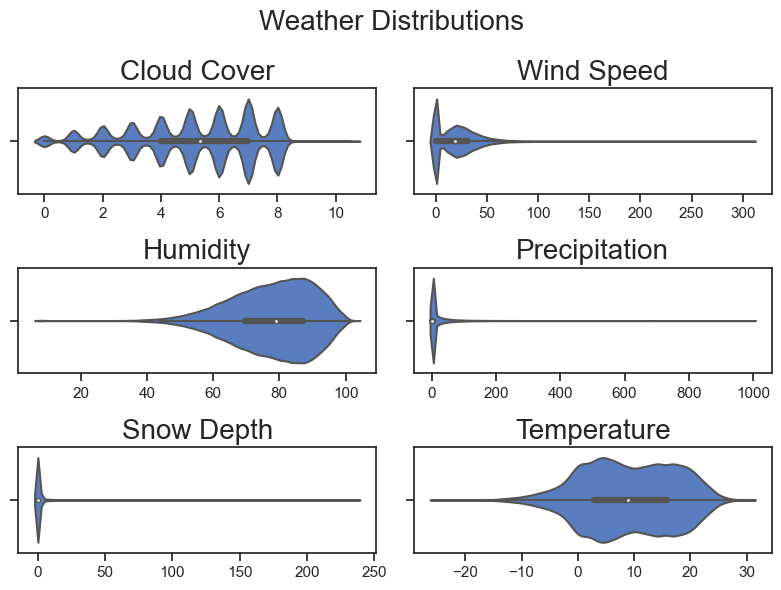

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), tight_layout=True)

for col, ax in zip(weather_cols, axes.flatten()):
    
    sns.violinplot(df[col], ax=ax);
    ax.set_title(weather_dict[col])
    ax.set_xlabel("")
    
plt.suptitle("Weather Distributions", fontsize=20);

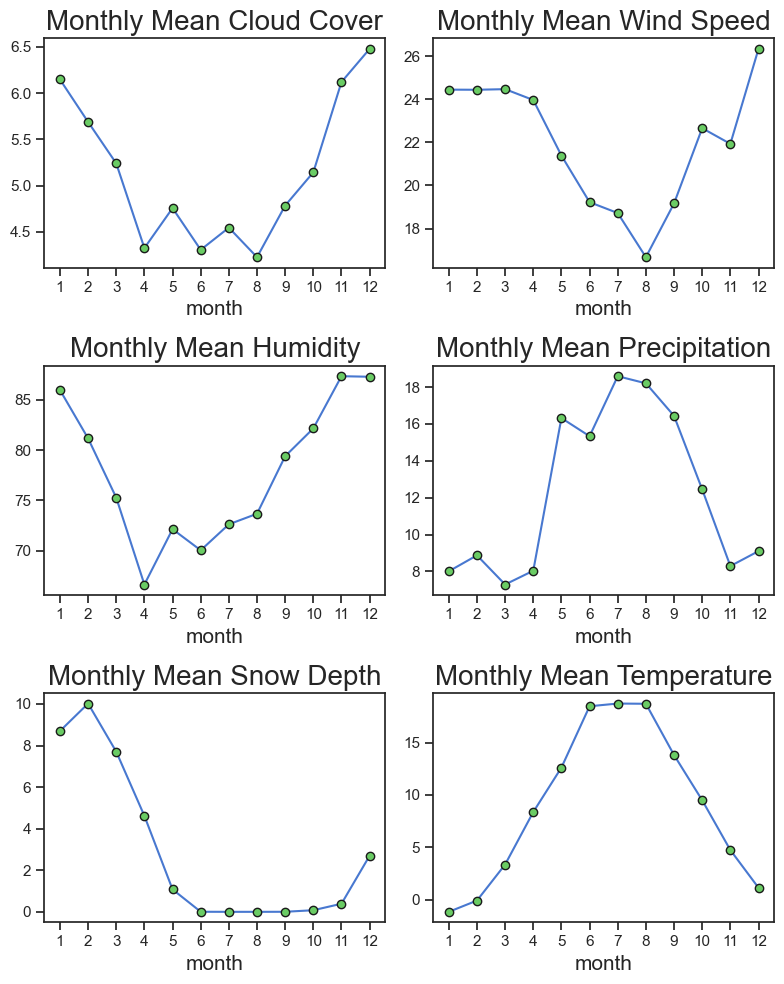

In [18]:
#Checking for monthly seasonality pattern
fig, axes = plt.subplots(3, 2, tight_layout=True, figsize=(8, 10))

for col, ax in zip(weather_cols, axes.flatten()):
    
    df.groupby('month')[col].mean().plot(ax=ax, marker="o", mfc="g", mec="k")
    ax.set_xticks(np.arange(1, 13, 1))
    ax.set_title(f'Monthly Mean {weather_dict[col]}');

* **Cloud Cover**: Cloud Covers are lowest during summers (April to Aug) and highest during winter months (Nov to Feb).


* **Wind Speed & Humidity**: Similar to cloud cover. The lowest mean wind speed is during August whereas the lowest mean humidity is on April.


* **Precipitation (Rail Fall)** is higher during July to Sep. Precipitation is lower during winter months.


* **Snow Depth**: Snow Depth is only observed significantly during the winter months from Dec to April.


* **Mean Temperature**: Temperature is highest during summer months from June to Aug. Temp is lowest during winter months of Dec to Feb.

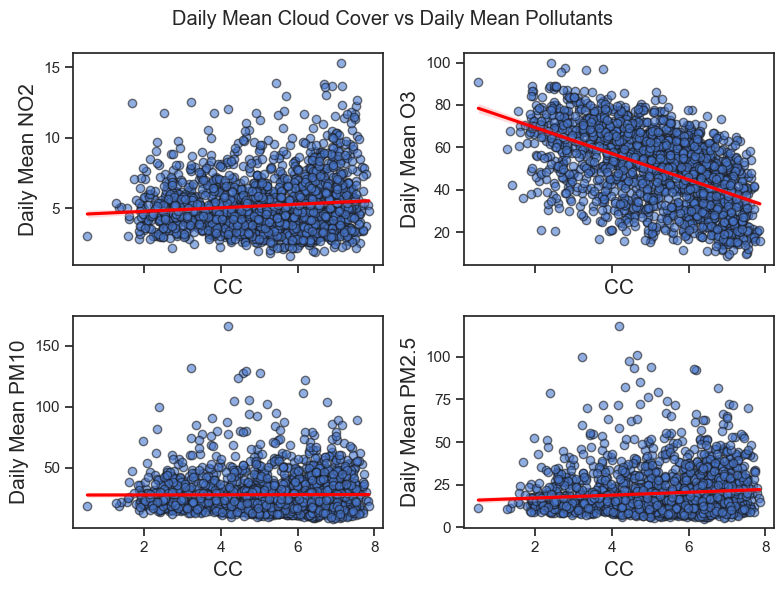

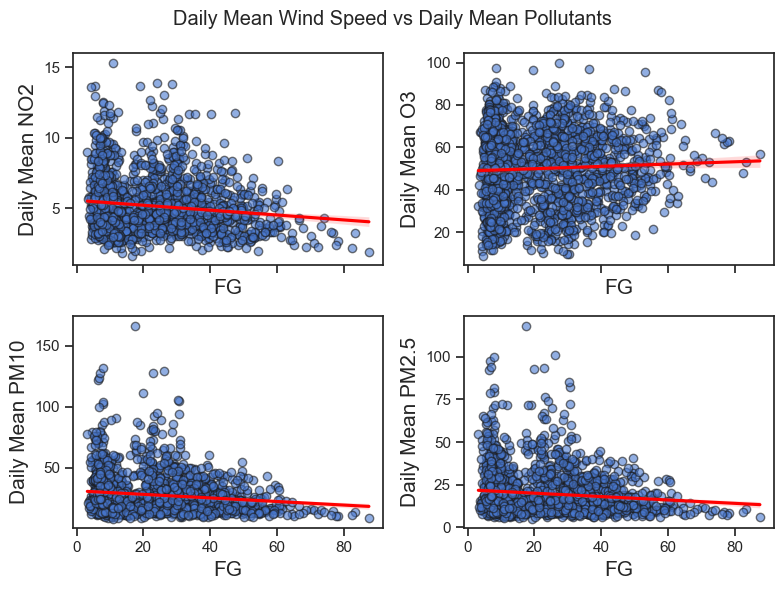

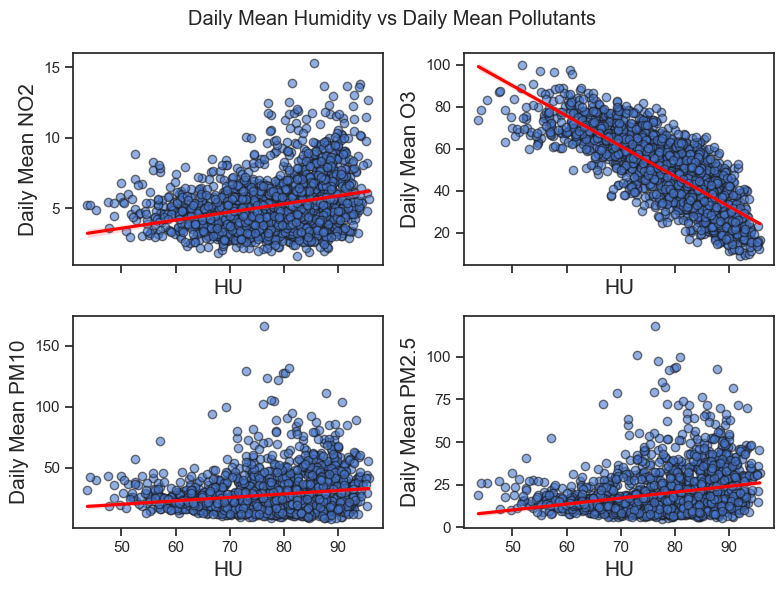

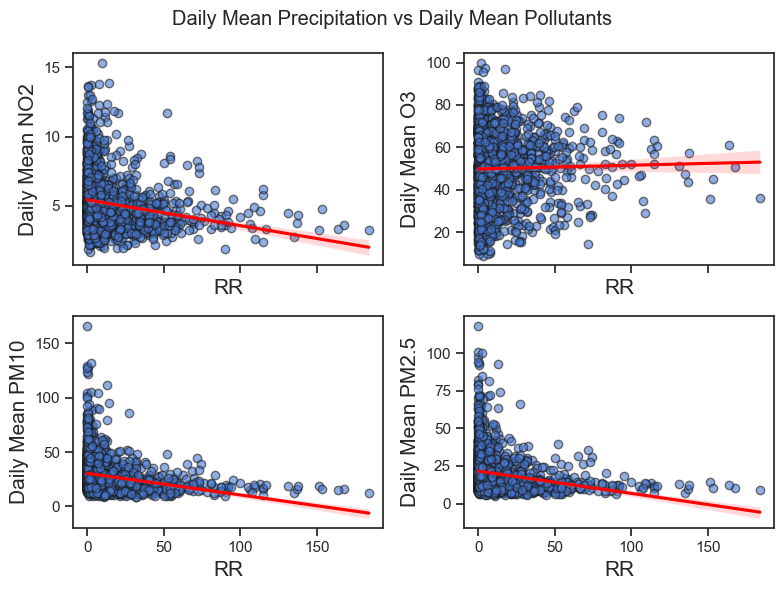

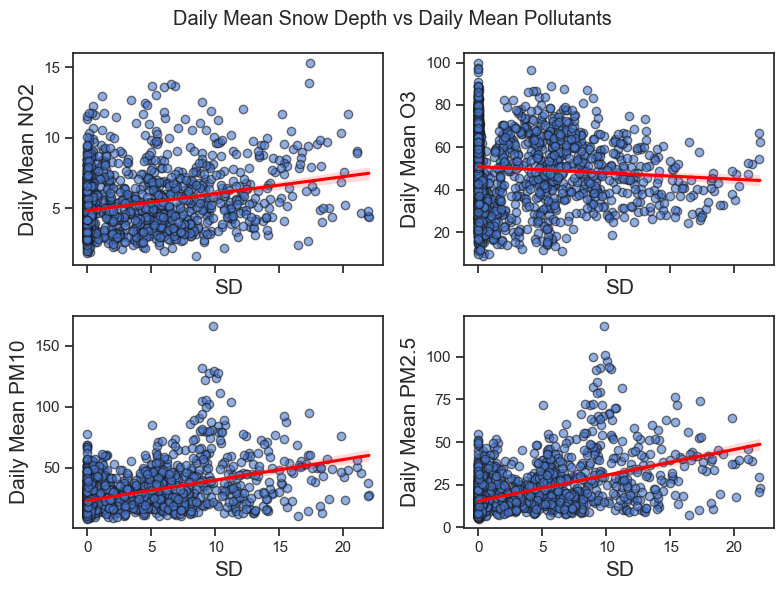

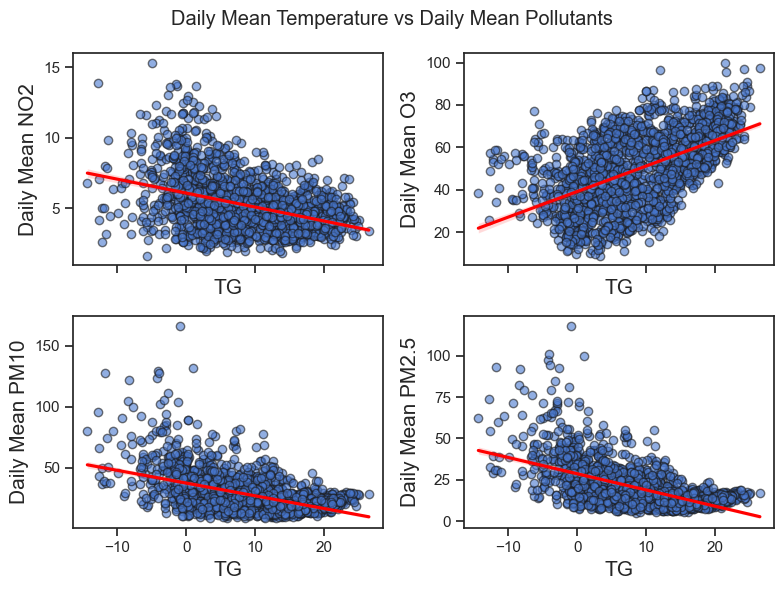

In [19]:
pol_wthr_agg = df.groupby('DATE')[pollutant_cols + weather_cols].mean()

for wthr_col in weather_cols:

    fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True, tight_layout=True)

    for pol_col, ax in zip(pollutant_cols, axes.flatten()):

        sns.regplot(x=wthr_col, y=pol_col, data=pol_wthr_agg, ax=ax, 
                    line_kws={'color' : 'red'}, scatter_kws={'edgecolor' : 'k', 'alpha' : 0.6})

        ax.set_ylabel(f"Daily Mean {poll_dict[pol_col]}");
        plt.suptitle(f"Daily Mean {weather_dict[wthr_col]} vs Daily Mean Pollutants");

Ozone seems to have some linear relation with cloud cover, humidity and temperature. For the rest of the variables, there is no discernible relations between pollution and weather variables = Except for temperature. There do seem to be some form of linear relation between temperature and the 4 pollutants.

In [20]:
#Dropping redundant columns
df = df.drop(["NO2_sub_idx", "O3_sub_idx", "PM10_sub_idx", "PM25_sub_idx"], axis=1)

# CAQI (Common Air Quality Index)

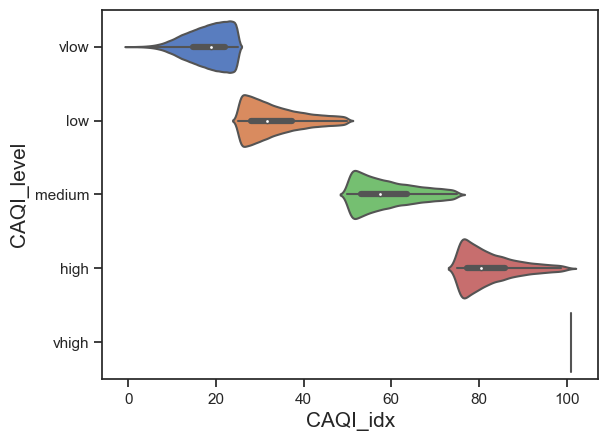

In [21]:
sns.violinplot(x='CAQI_idx', y='CAQI_level', data=df, orient='h');

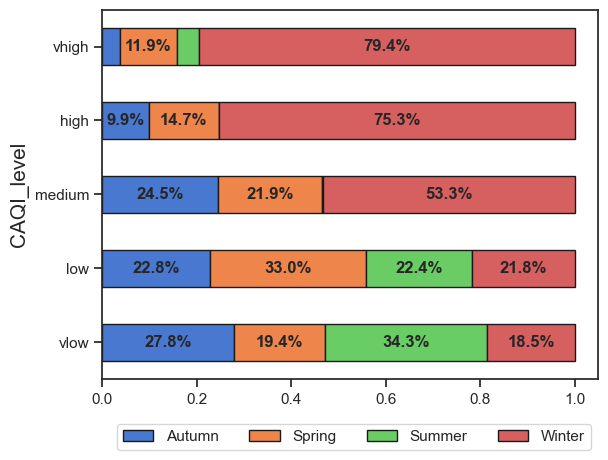

In [22]:
ax = pd.crosstab(columns=df['season'], index=df['CAQI_level'], normalize='index').\
        reindex(["vlow", "low", "medium", "high", "vhigh"]).\
            plot(kind='barh', stacked=True, edgecolor='k');

for c in ax.containers:
    # Filter the labels
    labels = [f'{np.round(v*100, 1)}%' if v > 0.05 else "" for v in c.datavalues]    
    ax.bar_label(c, labels=labels, label_type="center", fontweight = "bold")

ax.legend(ncol=5, bbox_to_anchor=(1, -0.1));

Winter seems to have the highest effect on overall air quality, as the CAQI levels are significantly higher during winter and lower during spring and summer.

In [23]:
mean_daily = df.groupby('DATE')[weather_cols+["CAQI_idx"]].mean()

mean_daily.loc[mean_daily.index.month.isin([9, 10, 11]), 'season'] = "Autumn"
mean_daily.loc[mean_daily.index.month.isin([12, 1, 2]), 'season'] = "Winter"
mean_daily.loc[mean_daily.index.month.isin([3, 4, 5]), 'season'] = "Spring"
mean_daily.loc[mean_daily.index.month.isin([6, 7, 8]), 'season'] = "Summer"

mean_daily.head()

CC         FG         HU         RR        SD        TG  \
DATE                                                                        
2017-01-01  4.969219  16.038114  84.417800   1.067211  1.506132 -0.509492   
2017-01-02  6.149754  49.997367  84.802305  13.419765  1.460113 -1.203916   
2017-01-03  6.443146  18.794046  86.698963  16.233819  3.157176 -1.255800   
2017-01-04  7.203707  83.294089  88.100274  31.031889  5.905389  0.356110   
2017-01-05  5.814259  16.571876  82.413417   1.664624  8.467116 -5.646726   

             CAQI_idx  season  
DATE                           
2017-01-01  54.196806  Winter  
2017-01-02  43.131935  Winter  
2017-01-03  27.514591  Winter  
2017-01-04  19.468726  Winter  
2017-01-05  23.753453  Winter

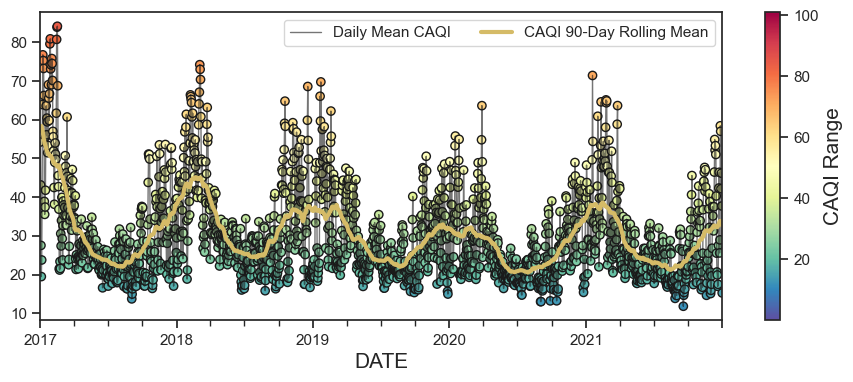

In [25]:
cmap = plt.get_cmap('Spectral_r')
vmin, vmax = df['CAQI_idx'].min(), df['CAQI_idx'].max()
norm = plt.Normalize(vmin=vmin, vmax=vmax)
colors = cmap(norm(mean_daily['CAQI_idx']))
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))

ax = mean_daily['CAQI_idx'].plot(figsize=(11, 4), color='k', alpha=0.6, label="Daily Mean CAQI", lw=1);

ax.scatter(mean_daily.index, mean_daily['CAQI_idx'], c=colors, cmap=cmap, edgecolor='k');

mean_daily['CAQI_idx'].rolling(90, center=True, min_periods=30).mean().\
    plot(ax=ax, c='y', lw=3, label="CAQI 90-Day Rolling Mean")

cbar.set_label('CAQI Range')

ax.legend(ncol=2, loc="upper right");

CAQI levels seemed to have been better during 2020. Similar to PM10 and PM2.5, CAQI levels seemed to be highest during 2017.

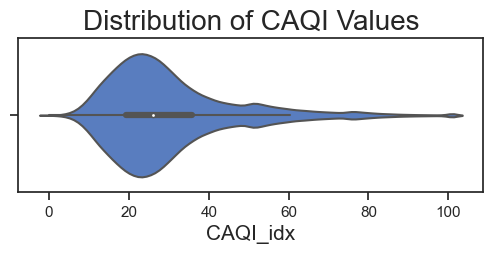

In [26]:
fig, ax = plt.subplots(figsize=(6, 2))

sns.violinplot(df['CAQI_idx'], ax=ax);

ax.set_title("Distribution of CAQI Values");

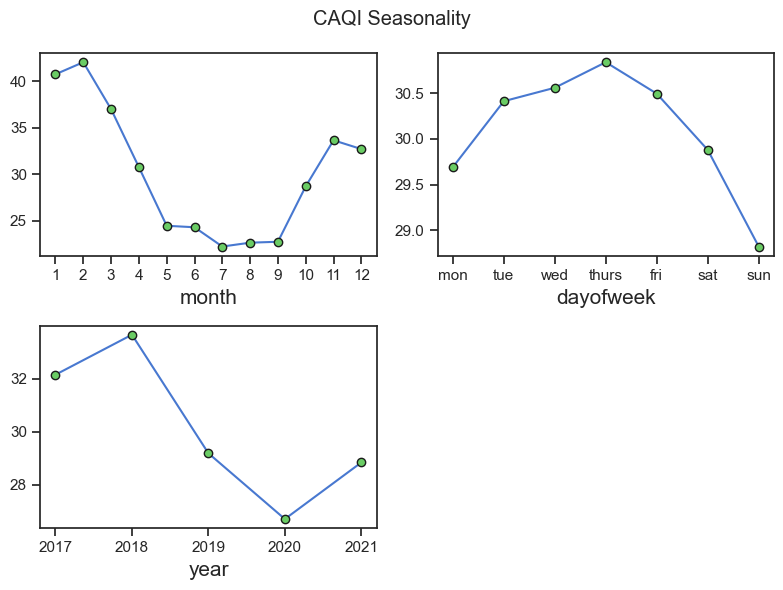

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6), tight_layout=True)

for col, ax in zip(['month', 'dayofweek', 'year'], axes.flatten()):
    
    df.groupby(col)['CAQI_idx'].mean().plot(ax=ax, marker="o", mfc="g", mec="k")
    
    if col=='dayofweek':
        ax.set_xticks(np.arange(7), days)
    elif col=='month':
        ax.set_xticks(np.arange(1, 13, 1))
        
axes.flatten()[-1].set_axis_off()

plt.suptitle('CAQI Seasonality');

CAQI levels are lowest during summer and highest during winter. CAQI levels are lower during weekends.

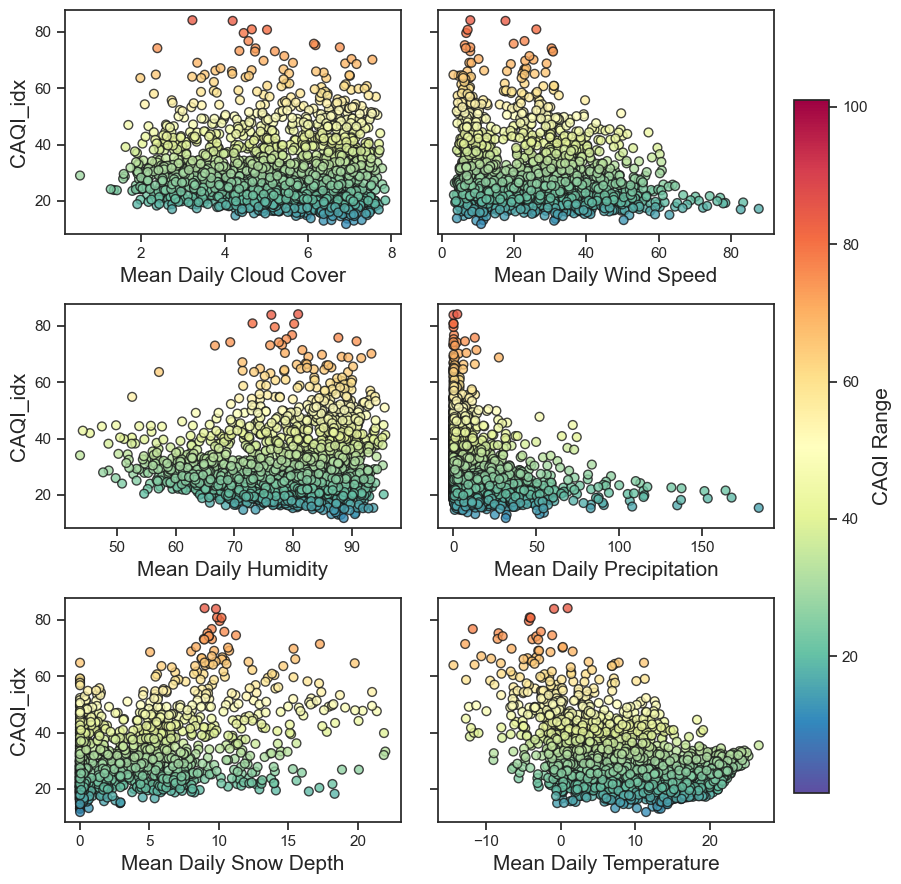

In [28]:
fig, axes = plt.subplots(3, 2, figsize=(8, 9), sharey=True, tight_layout=True)

for col, ax in zip(weather_cols, axes.flatten()):
    
    cax = mean_daily.plot(x=col, y='CAQI_idx', kind='scatter', edgecolor='k', ax=ax, alpha=0.8, s=40,
                          c=colors, cmap=cmap);
    
    cax.collections[0].colorbar.remove() # Remove colorbar
    
    ax.set_xlabel(f"Mean Daily {weather_dict[col]}");

# Add common color bar at the bottom
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes.ravel().tolist(), anchor=(3, 0.5))
cbar.set_label('CAQI Range')

Except for temeprature, there seems to be no apparant relation between CAQI and weather. For temeprature, as the temperature increases, the CAQI levels seems to be lower.

In [35]:
df

index                              powiat_voivod       DATE  \
0            0  powiat aleksandrowski, kujawsko-pomorskie 2017-01-01   
1            1  powiat aleksandrowski, kujawsko-pomorskie 2017-01-02   
2            2  powiat aleksandrowski, kujawsko-pomorskie 2017-01-03   
3            3  powiat aleksandrowski, kujawsko-pomorskie 2017-01-04   
4            4  powiat aleksandrowski, kujawsko-pomorskie 2017-01-05   
...        ...                                        ...        ...   
361543  361543                   powiat żywiecki, śląskie 2021-12-27   
361544  361544                   powiat żywiecki, śląskie 2021-12-28   
361545  361545                   powiat żywiecki, śląskie 2021-12-29   
361546  361546                   powiat żywiecki, śląskie 2021-12-30   
361547  361547                   powiat żywiecki, śląskie 2021-12-31   

              LAT        LON  NO2_24H_AVG_POLLUTION  O3_24H_AVG_POLLUTION  \
0       52.888422  18.780908                    NaN                 32.22   
1       52.888422  18.780908                    NaN                 34.62   
2       52.888422  18.780908                    NaN                 42.00   
3       52.888422  18.780908                    NaN                 57.46   
4       52.888422  18.780908                    NaN                 64.62   
...           ...        ...                    ...                   ...   
361543  49.671602  19.234446                    NaN                   NaN   
361544  49.671602  19.234446                    NaN                   NaN   
361545  49.671602  19.234446                    NaN                   NaN   
361546  49.671602  19.234446                    NaN                   NaN   
361547  49.671602  19.234446                    NaN                   NaN   

        PM10_24H_AVG_POLLUTION  PM25_24H_AVG_POLLUTION        CC  ...  \
0                    24.968064                     NaN  4.746750  ...   
1                    17.943745                     NaN  6.167555  ...   
2                    14.477950                     NaN  5.198131  ...   
3                     8.418471                     NaN  8.432231  ...   
4                    13.189740                     NaN  4.992977  ...   
...                        ...                     ...       ...  ...   
361543              158.600000                     NaN  5.000000  ...   
361544              173.700000                     NaN  7.000000  ...   
361545               35.300000                     NaN  7.000000  ...   
361546               21.800000                     NaN  8.000000  ...   
361547                6.400000                     NaN  6.000000  ...   

        [crop production] rape and turnip rape, area in ha, total  \
0                                                  2616.0           
1                                                  2616.0           
2                                                  2616.0           
3                                                  2616.0           
4                                                  2616.0           
...                                                   ...           
361543                                             1838.0           
361544                                             1838.0           
361545                                             1838.0           
361546                                             1838.0           
361547                                             1838.0           

        [crop production] permanent meadows, area in ha, total  \
0                                                  2320.0        
1                                                  2320.0        
2                                                  2320.0        
3                                                  2320.0        
4                                                  2320.0        
...                                                   ...        
361543                                             